In [ ]:
# Configuracion
import os
import multiprocessing

os.environ["LOKY_MAX_CPU_COUNT"] = str(multiprocessing.cpu_count())

# Librarias principales
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Guardado de modelos
from pathlib import Path
import joblib

# Agregar el directorio src al path
import sys
sys.path.append('../../src')

from visualization import graficar_roc_auc, graficar_confusion_matrix

<b> Ahora Se va empezar lo entrenamiento de los modelos. Es importante que en nuestro pipeline de entrenamiento Se necesita de un balancing </b>
- Voy hacer o balancing por SMOTE+Undersample listo que Se tienen muchas lineas, si no va a ser un entrenamiento super grande.
- Se va empezar con modelos simples Logistic Regression and Simple decision tree y tambien usando solo las variables que Se tienen al principio sin la Feature enginnering
- Se va crear un standardized para logistic y un no standardized para decision tree
- Despues intentaremos ensemble mejores y por fin con lo mejor modelo voy aplicar Optuna

In [106]:
df_devices = pd.read_parquet('../../data/01_processed/full_devices.parquet')

In [107]:
df_devices = df_devices[['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']].copy()

In [108]:
# df = pd.read_csv("tu_dataset.csv")
X = df_devices.drop(columns=['date', 'device', 'failure'])
y = df_devices['failure']

# Dividir en train y test ANTES de hacer el balanceo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Definir el pipeline: primero SMOTE (oversampling), luego undersampling
over = SMOTE(sampling_strategy=0.1, random_state=42)   # Aumenta la clase minoritaria hasta el 10% de la mayoritaria
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Reduce la mayoritaria hasta un balance 50:50
steps = [('o', over), ('u', under)]
resample_pipeline = Pipeline(steps=steps)

In [109]:
# Aplicar el balanceo solo al conjunto de entrenamiento
X_train_res, y_train_res = resample_pipeline.fit_resample(X_train, y_train)

PROD = Path("../../production")
( PROD / "pipeline" ).mkdir(parents=True, exist_ok=True)

joblib.dump(X_train_res, PROD / "pipeline" / "X_train_sin_se.joblib")
joblib.dump(y_train_res, PROD / "pipeline" / "y_train_sin_se.joblib")
joblib.dump(X_test,      PROD / "pipeline" / "X_test_sin_se.joblib")
joblib.dump(y_test,      PROD / "pipeline" / "y_test_sin_se.joblib")

print("Antes del balanceo:", y_train.value_counts())
print("Después del balanceo:", y_train_res.value_counts())

Antes del balanceo: failure
0    99510
1       85
Name: count, dtype: int64
Después del balanceo: failure
0    19902
1     9951
Name: count, dtype: int64


# Regression Logistica

In [110]:
# Crear el pipeline: estandarización + regresión logística
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandariza las variables
    ('logreg', LogisticRegression(
        class_weight='balanced',    # Manejo de desbalance adicional
        max_iter=1000,              # Aumenta iteraciones por convergencia
        random_state=42
    ))
])

In [111]:
# Entrenar con el dataset balanceado
logreg_pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [112]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
y_train_pred = logreg_pipeline.predict(X_train_res)
y_test_pred = logreg_pipeline.predict(X_test)

In [113]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.850     0.968     0.905     19902
           1      0.911     0.659     0.764      9951

    accuracy                          0.865     29853
   macro avg      0.880     0.813     0.835     29853
weighted avg      0.870     0.865     0.858     29853



In [114]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.965     0.982     24878
           1      0.015     0.619     0.029        21

    accuracy                          0.964     24899
   macro avg      0.507     0.792     0.505     24899
weighted avg      0.999     0.964     0.981     24899



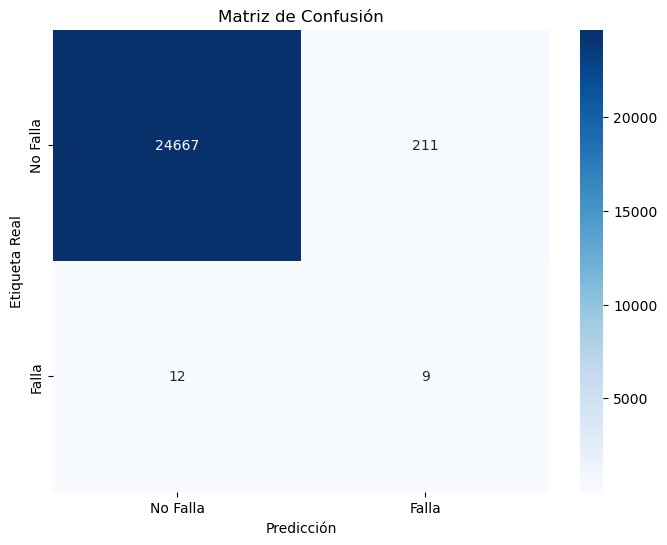

array([[24667,   211],
       [   12,     9]], dtype=int64)

In [115]:
graficar_confusion_matrix(y_test, y_pred)

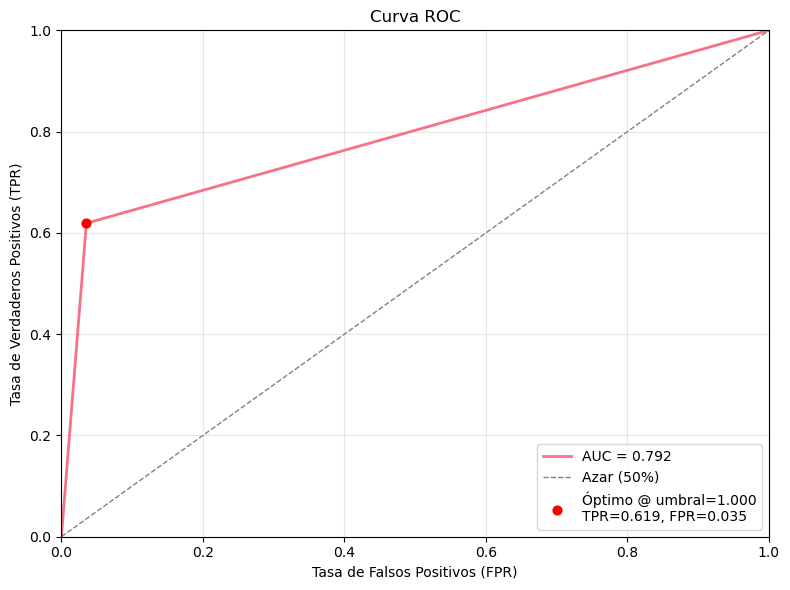

{'AUC': 0.7918776964922153,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.6190476190476191,
 'FPR óptimo': 0.03529222606318836}

In [116]:
graficar_roc_auc(y_test, y_test_pred)

<b> Se tienen un super overfitting con nuestra regression logistica </b>
- Para un start está bueño listo que estamos pegando al menos 60% de los casos de fallas
- Se va intentar con la decision tree

# Arbore de decision

In [117]:
# Pipeline: solo el clasificador (no requiere escalado)
tree_pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(
        class_weight='balanced',   # Ajusta pesos para clases desbalanceadas
        max_depth=None,            # Sin límite inicial (puedes ajustar)
        random_state=42
    ))
])

In [118]:
# Entrenar con el dataset balanceado
tree_pipeline.fit(X_train_res, y_train_res)

Pipeline(steps=[('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [119]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
y_train_pred = tree_pipeline.predict(X_train_res)
y_test_pred = tree_pipeline.predict(X_test)

In [120]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     19902
           1      1.000     1.000     1.000      9951

    accuracy                          1.000     29853
   macro avg      1.000     1.000     1.000     29853
weighted avg      1.000     1.000     1.000     29853



In [121]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.988     0.993     24878
           1      0.022     0.333     0.041        21

    accuracy                          0.987     24899
   macro avg      0.511     0.660     0.517     24899
weighted avg      0.999     0.987     0.993     24899



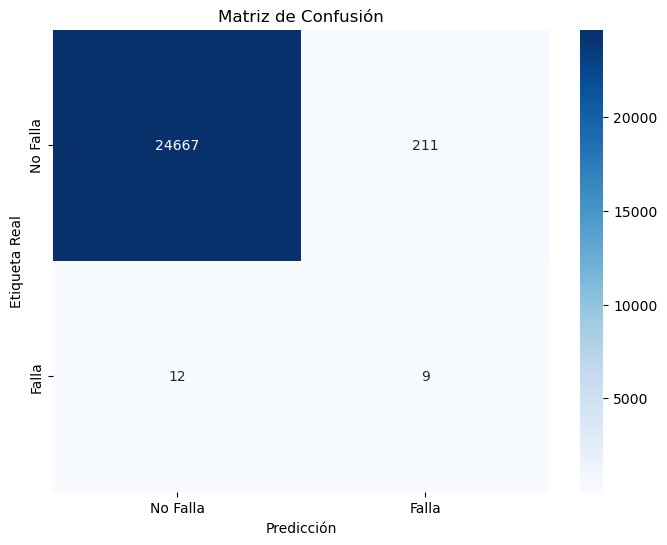

array([[24667,   211],
       [   12,     9]], dtype=int64)

In [122]:
graficar_confusion_matrix(y_test, y_pred)

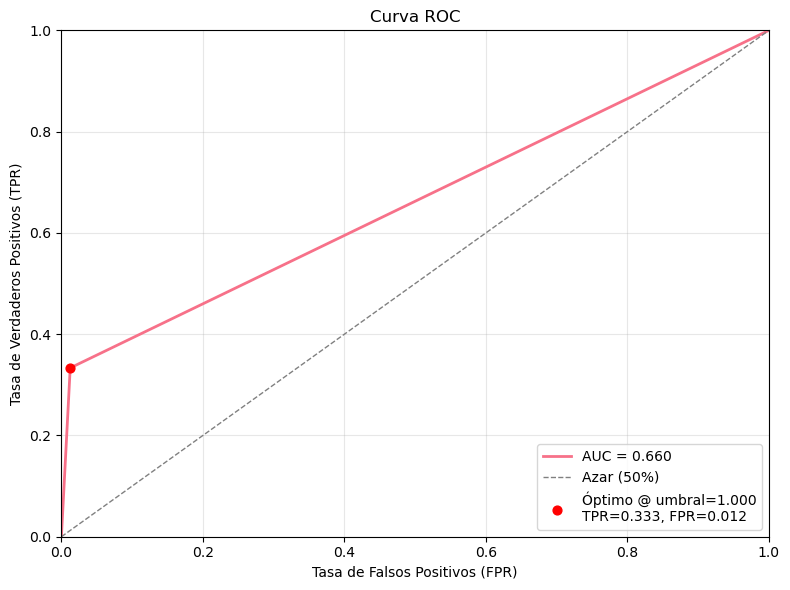

{'AUC': 0.6604362622933247,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.3333333333333333,
 'FPR óptimo': 0.012460808746683818}

In [123]:
graficar_roc_auc(y_test, y_test_pred)

<b> Acá está muy pior estamos con muchos errores en las fallas y eres o que no Se quiere </b>
- Tambien no hiciemos ningun tipo de otimizacion de hyperparametros
- Antes de intentar mejorar con otimizacion de hyperparametros Se va intentar un ensemble model como xgboost, despues pasamos a correr un optuna sin feature engineering

# XGBoost

In [124]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200
)

In [125]:
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [126]:
# Predicciones
y_pred = xgb_model.predict(X_test)

# Métricas
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.992     0.996     24878
           1      0.041     0.429     0.075        21

    accuracy                          0.991     24899
   macro avg      0.520     0.710     0.535     24899
weighted avg      0.999     0.991     0.995     24899



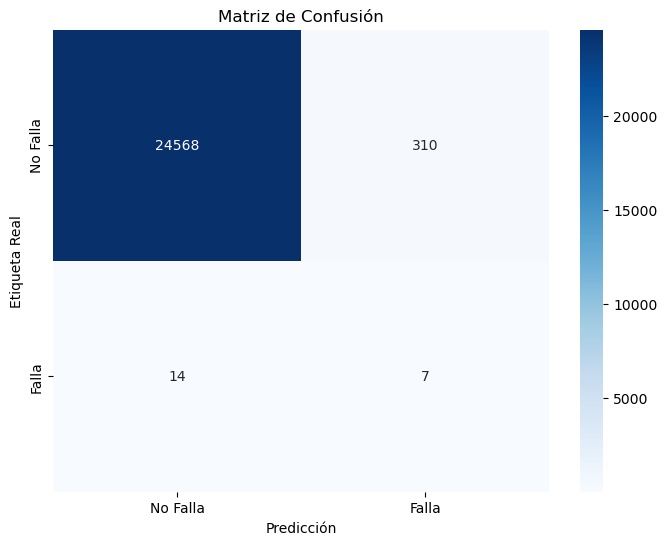

array([[24568,   310],
       [   14,     7]], dtype=int64)

In [127]:
graficar_confusion_matrix(y_test, y_test_pred)

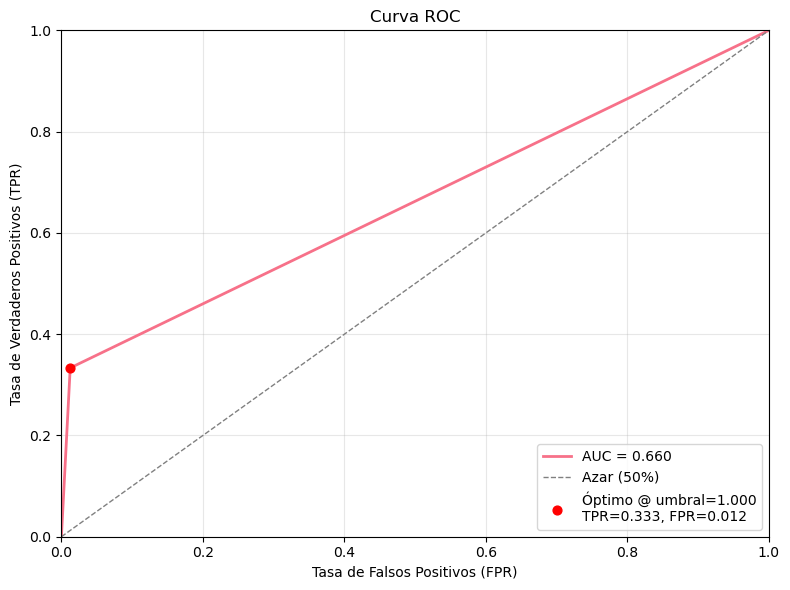

{'AUC': 0.6604362622933247,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.3333333333333333,
 'FPR óptimo': 0.012460808746683818}

In [128]:
graficar_roc_auc(y_test, y_test_pred)

<b> XGboost </b> Demonstro un poquito más de potencial que la arbore de decision, Se va intentar lo optuna con XGBoost entonces
- Despues intentaremos Se añadirá las nuevas variables que crée

# Optuna

In [129]:
STORAGE_URL = f"sqlite:///{Path('../../production/pipeline/optuna_study_sin_se.db').as_posix()}"
STUDY_NAME  = "xgb_failure_pred_sin_se"

study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)

study.best_value, study.best_params  # (mejor métrica, dict de hiperparámetros)


(0.9909774436090225,
 {'learning_rate': 0.25324824386169287,
  'n_estimators': 243,
  'max_depth': 8,
  'min_child_weight': 0.0012616494222155502,
  'gamma': 0.07630363557830899,
  'subsample': 0.7241640005770421,
  'colsample_bytree': 0.9968149299064681,
  'colsample_bylevel': 0.9984066126989742,
  'reg_alpha': 0.8232590945089133,
  'reg_lambda': 0.021357228787349004})

In [130]:
model = XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9984066126989742, colsample_bynode=None,
              colsample_bytree=0.9968149299064681, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.07630363557830899, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25324824386169287,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.0012616494222155502, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=243,
              n_jobs=None, num_parallel_tree=None, ...)

In [131]:
# Predecir sobre el conjunto de prueba original (desbalanceado)
y_train_pred = model.predict(X_train_res)
y_test_pred = model.predict(X_test)

In [132]:
# Métricas de evaluación
print(classification_report(y_train_res, y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.741     1.000     0.851     19902
           1      1.000     0.300     0.462      9951

    accuracy                          0.767     29853
   macro avg      0.870     0.650     0.656     29853
weighted avg      0.827     0.767     0.721     29853



In [133]:
# Métricas de evaluación
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.999     0.999     24878
           1      0.088     0.143     0.109        21

    accuracy                          0.998     24899
   macro avg      0.544     0.571     0.554     24899
weighted avg      0.999     0.998     0.998     24899



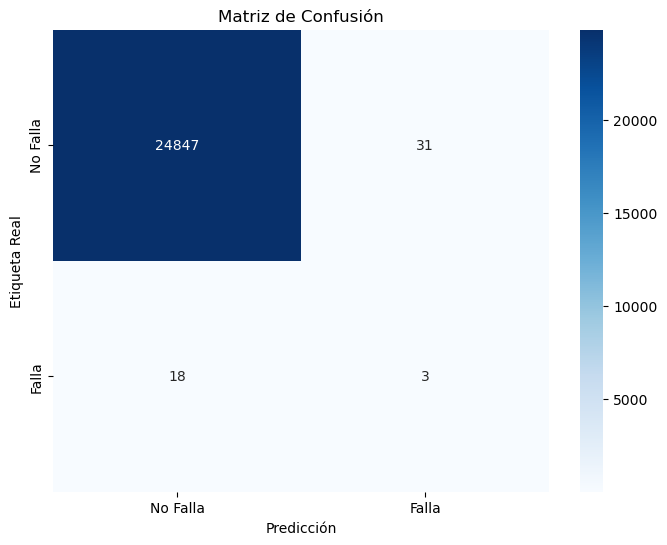

array([[24847,    31],
       [   18,     3]], dtype=int64)

In [134]:
graficar_confusion_matrix(y_test, y_test_pred)

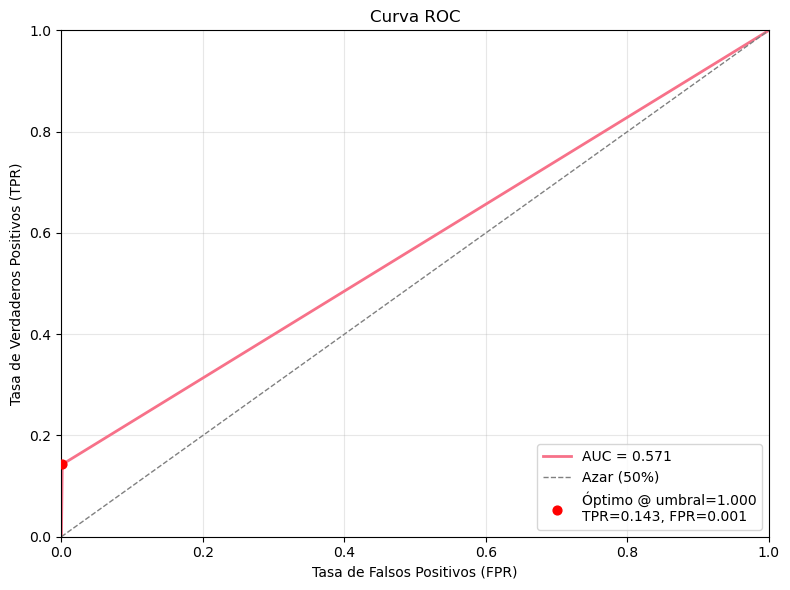

{'AUC': 0.5708055309912372,
 'Umbral óptimo': 1.0,
 'TPR óptimo': 0.14285714285714285,
 'FPR óptimo': 0.0012460808746683817}

In [135]:
graficar_roc_auc(y_test, y_test_pred)

<b> Lo grand Problema es que optuna es un challenge para se crear un pipeline donde enfoque mucho en gañar recall sin tener overfitting, portanto la regression aun se sali mejor </b>